# Download data from MNIST
We download data from an online source(deeplearning.net) to local directory.
The data is deserialized using pickle into tuples for train / test

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
if not PATH.exists():
    PATH.mkdir(parents=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f)

In [3]:
print ("Training set shape, x_train = {}, y_train = {}".format(x_train.shape, y_train.shape))

Training set shape, x_train = (50000, 784), y_train = (50000,)


In [4]:
print ("Validation set shape, x_valid = {}, y_valid = {}".format(x_valid.shape, y_valid.shape))

Validation set shape, x_valid = (10000, 784), y_valid = (10000,)


In [5]:
print ("Test set shape, x_test = {}, y_test = {}".format(x_test.shape, y_test.shape))

Test set shape, x_test = (10000, 784), y_test = (10000,)


# Display input with label
In this section we write some utils to display input with labels

In [6]:
import matplotlib.pyplot as plt
import torch

In [7]:
def display_example(x_train, y_train, N=0):
    plt.imshow(x_train[N].reshape((28, 28)), cmap="gray")
    plt.title("digit label = {}".format(y_train[N]))

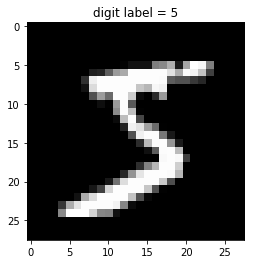

In [8]:
display_example(x_train, y_train)

In [9]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

In [10]:
n, c = x_train.shape
print("Training set has {} examples with {} features each".format(n,c))
print("Training labels are in range [{}, {}]".format(y_train.min(), y_train.max()))

Training set has 50000 examples with 784 features each
Training labels are in range [0, 9]


## NN from scrath
In this section, we implement a neural network without torch.nn
using basic torch tensors

In [11]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [12]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb, weights, bias):
#    return log_softmax(xb @ weights + bias)
    return log_softmax(xb.mm(weights) + bias)

In [13]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [14]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb, weights, bias)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

(tensor([-2.4968, -2.6604, -2.9775, -2.3970, -1.8815, -1.9540, -1.8290, -2.3706,
        -2.5417, -2.5381], grad_fn=<SelectBackward>), torch.Size([64, 10]))


In [15]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3406, grad_fn=<NegBackward>)


In [16]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [17]:
print(accuracy(preds, yb))

tensor(0.0625)


In [18]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

with torch.no_grad():
    print ("Accuracy on training on initial weights = {}%%".
           format(loss_func(model(x_train, weights, bias), y_train), 100*accuracy(model(x_train, weights, bias), y_train)))
    print ("Accuracy on validation  on initial weights = {}%%".
           format( loss_func(model(x_valid, weights, bias), y_valid), 100*accuracy(model(x_valid, weights, bias), y_valid)))

lr = 0.5
bs = 64
epochs = 5
for e in range(epochs):
    for i in range (n/bs):
        xb = x_train[i*bs:min(n, (i+1)*bs)]  # a mini-batch from x
        yb = y_train[i*bs:min(n, (i+1)*bs)]
        preds = model(xb, weights, bias)  # predictions
        loss = loss_func(preds, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

    with torch.no_grad():
        print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
               format(e, loss_func(model(x_train, weights, bias), y_train), 100*accuracy(model(x_train, weights, bias), y_train)))
        print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
               format(e, loss_func(model(x_valid, weights, bias), y_valid), 100*accuracy(model(x_valid, weights, bias), y_valid)))
    #    weights = weights - learning_rate * weights.grad
    #    bias = bias - learning_rate * bias.grad

Accuracy on training on initial weights = 2.31931591034%%
Accuracy on validation  on initial weights = 2.31978702545%%
Accuracy on training after epoch#0, loss = 0.326205164194, acc = 90.5159988403%%
Accuracy on validation after epoch#0, loss = 0.30722245574, acc = 91.2799987793%%
Accuracy on training after epoch#1, loss = 0.306680738926, acc = 91.1279983521%%
Accuracy on validation after epoch#1, loss = 0.293733656406, acc = 91.7799987793%%
Accuracy on training after epoch#2, loss = 0.297901064157, acc = 91.4659957886%%
Accuracy on validation after epoch#2, loss = 0.2889072299, acc = 91.9000015259%%
Accuracy on training after epoch#3, loss = 0.292455583811, acc = 91.5799942017%%
Accuracy on validation after epoch#3, loss = 0.286613762379, acc = 92.0099945068%%
Accuracy on training after epoch#4, loss = 0.28855574131, acc = 91.7320022583%%
Accuracy on validation after epoch#4, loss = 0.285406827927, acc = 92.0400009155%%


# Refactor using torch.nn.functional
In this section we refactor our above code and use functional package

In [19]:
import torch.nn.functional as F

In [20]:
loss_func = F.cross_entropy
def forward(xb, weights, bias):
    return xb.mm(weights) + bias

In [21]:
with torch.no_grad():
    print(loss_func(forward(x_valid, weights, bias), y_valid), accuracy(forward(x_valid, weights, bias), y_valid))

(tensor(0.2854), tensor(0.9204))


# Train using functional package
We repeat same exercise using functional package. Try to implement everything on your own

In [22]:
w = torch.randn(784, 10) / math.sqrt(784.0)
w.requires_grad_()
b = torch.zeros(10, requires_grad=True)

with torch.no_grad():
    print(loss_func(forward(x_valid, w, b), y_valid), accuracy(forward(x_valid, w, b), y_valid))

with torch.no_grad():
    print ("Accuracy on training on initial weights = {}%%".
           format(loss_func(model(x_train, weights, bias), y_train), 100*accuracy(model(x_train, weights, bias), y_train)))
    print ("Accuracy on validation  on initial weights = {}%%".
           format( loss_func(model(x_valid, weights, bias), y_valid), 100*accuracy(model(x_valid, weights, bias), y_valid)))

    
lr = 0.5
epochs = 10
bs = 64
for e in range(epochs):
    for i in range(n/bs):
        b_start = i*bs
        b_end = min(n, (i+1)*bs)
        xb = x_train[b_start:b_end]
        yb = y_train[b_start:b_end]
        pred = forward(xb, w, b)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            w -= w.grad*lr
            b -= b.grad*lr
            w.grad.zero_()
            b.grad.zero_()
    
    with torch.no_grad():
        print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
               format(e, loss_func(model(x_train, weights, bias), y_train), 100*accuracy(model(x_train, weights, bias), y_train)))
        print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
               format(e, loss_func(model(x_valid, weights, bias), y_valid), 100*accuracy(model(x_valid, weights, bias), y_valid)))

(tensor(2.3208), tensor(0.0881))
Accuracy on training on initial weights = 0.288550287485%%
Accuracy on validation  on initial weights = 0.285406172276%%
Accuracy on training after epoch#0, loss = 0.288550287485, acc = 91.7320022583%%
Accuracy on validation after epoch#0, loss = 0.285406172276, acc = 92.0400009155%%
Accuracy on training after epoch#1, loss = 0.288550287485, acc = 91.7320022583%%
Accuracy on validation after epoch#1, loss = 0.285406172276, acc = 92.0400009155%%
Accuracy on training after epoch#2, loss = 0.288550287485, acc = 91.7320022583%%
Accuracy on validation after epoch#2, loss = 0.285406172276, acc = 92.0400009155%%
Accuracy on training after epoch#3, loss = 0.288550287485, acc = 91.7320022583%%
Accuracy on validation after epoch#3, loss = 0.285406172276, acc = 92.0400009155%%
Accuracy on training after epoch#4, loss = 0.288550287485, acc = 91.7320022583%%
Accuracy on validation after epoch#4, loss = 0.285406172276, acc = 92.0400009155%%
Accuracy on training after

# Use nn module
Now we use nn.module to encapsulate the model

In [23]:
import torch.nn as nn

In [24]:
from torch import nn
class MnistLogistic(nn.Module):
    def __init__(self):
        super(MnistLogistic, self).__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb.mm(self.weights) + self.bias

In [25]:
def fit(model, x_train, y_train, x_valid, y_valid, bs = 64, lr = 0.5):
    n, num_feats = x_train.shape
    with torch.no_grad():
        print ("Accuracy on training on initial weights = {}%%".
               format(loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
        print ("Accuracy on validation  on initial weights = {}%%".
               format( loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))
    
    for e in range(epochs):
        for i in range(n/bs):
            b_start = i*bs
            b_end = min(n, (i+1)*bs)
            xb = x_train[b_start:b_end]
            yb = y_train[b_start:b_end]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        
        with torch.no_grad():
            print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
            print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))

In [26]:
model = MnistLogistic()
fit(model, x_train, y_train, x_valid, y_valid)

Accuracy on training on initial weights = 2.39047789574%%
Accuracy on validation  on initial weights = 2.38573241234%%
Accuracy on training after epoch#0, loss = 0.325614720583, acc = 90.6180038452%%
Accuracy on validation after epoch#0, loss = 0.306369125843, acc = 91.3699951172%%
Accuracy on training after epoch#1, loss = 0.306063920259, acc = 91.2119979858%%
Accuracy on validation after epoch#1, loss = 0.292879462242, acc = 91.7999954224%%
Accuracy on training after epoch#2, loss = 0.297343254089, acc = 91.5039978027%%
Accuracy on validation after epoch#2, loss = 0.288161635399, acc = 91.8699951172%%
Accuracy on training after epoch#3, loss = 0.291963636875, acc = 91.6699981689%%
Accuracy on validation after epoch#3, loss = 0.285972833633, acc = 91.9899978638%%
Accuracy on training after epoch#4, loss = 0.288119226694, acc = 91.7340011597%%
Accuracy on validation after epoch#4, loss = 0.284847646952, acc = 92.0899963379%%
Accuracy on training after epoch#5, loss = 0.285144656897, ac

In [27]:
from torch import nn
class MnistLogisticB(nn.Module):
    def __init__(self):
        super(MnistLogisticB, self).__init__()
        self.fc1 = nn.Linear(784, 10)
    
    def forward(self, xb):
        return self.fc1(xb)

In [28]:
modelB = MnistLogisticB()
fit(model, x_train, y_train, x_valid, y_valid)

Accuracy on training on initial weights = 0.277382791042%%
Accuracy on validation  on initial weights = 0.284105479717%%
Accuracy on training after epoch#0, loss = 0.276008754969, acc = 92.0719985962%%
Accuracy on validation after epoch#0, loss = 0.284299254417, acc = 92.1199951172%%
Accuracy on training after epoch#1, loss = 0.274771183729, acc = 92.1180038452%%
Accuracy on validation after epoch#1, loss = 0.284535437822, acc = 92.1199951172%%
Accuracy on training after epoch#2, loss = 0.273644298315, acc = 92.1380004883%%
Accuracy on validation after epoch#2, loss = 0.28479719162, acc = 92.1299972534%%
Accuracy on training after epoch#3, loss = 0.272611320019, acc = 92.1760025024%%
Accuracy on validation after epoch#3, loss = 0.285082489252, acc = 92.1699981689%%
Accuracy on training after epoch#4, loss = 0.27165979147, acc = 92.18800354%%
Accuracy on validation after epoch#4, loss = 0.285378545523, acc = 92.1100006104%%
Accuracy on training after epoch#5, loss = 0.270777732134, acc 

# Use optim module
Now we make use of Adam optimizer from optim module and use it instead of manually updaing the parameters

In [29]:
from torch import optim

In [30]:
modelB2 = MnistLogisticB()
optimizer = optim.SGD(modelB2.parameters(), lr=0.1)

In [31]:
def fitB(model, opt, x_train, y_train, x_valid, y_valid, bs = 64):
    n, num_feats = x_train.shape
    with torch.no_grad():
        print ("Accuracy on training on initial weights = {}%%".
               format(loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
        print ("Accuracy on validation  on initial weights = {}%%".
               format( loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))
    
    for e in range(epochs):
        for i in range(n/bs):
            b_start = i*bs
            b_end = min(n, (i+1)*bs)
            xb = x_train[b_start:b_end]
            yb = y_train[b_start:b_end]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                opt.step()
                opt.zero_grad()
        
        with torch.no_grad():
            print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
            print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))

In [32]:
fitB(modelB2, optimizer, x_train, y_train, x_valid, y_valid)

Accuracy on training on initial weights = 2.28835773468%%
Accuracy on validation  on initial weights = 2.28492593765%%
Accuracy on training after epoch#0, loss = 0.371194839478, acc = 89.59400177%%
Accuracy on validation after epoch#0, loss = 0.340248942375, acc = 90.7900009155%%
Accuracy on training after epoch#1, loss = 0.33239492774, acc = 90.675994873%%
Accuracy on validation after epoch#1, loss = 0.309105068445, acc = 91.5599975586%%
Accuracy on training after epoch#2, loss = 0.314870983362, acc = 91.1699981689%%
Accuracy on validation after epoch#2, loss = 0.295534074306, acc = 91.7099990845%%
Accuracy on training after epoch#3, loss = 0.304248064756, acc = 91.4459991455%%
Accuracy on validation after epoch#3, loss = 0.287535250187, acc = 91.8899993896%%
Accuracy on training after epoch#4, loss = 0.296892702579, acc = 91.6819992065%%
Accuracy on validation after epoch#4, loss = 0.28215688467, acc = 92.0199966431%%
Accuracy on training after epoch#5, loss = 0.291392236948, acc = 9

## Use dataset
Now we implement a dataset to provide an iterator on mini-batches of mnist

In [33]:
from torch.utils.data import TensorDataset

In [34]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
modelB3 = MnistLogisticB()
optimizer = optim.SGD(modelB3.parameters(), lr=0.1)

In [35]:
def fitC(model, opt, train_ds, valid_ds, bs = 64):
    n, num_feats = x_train.shape
    with torch.no_grad():
        print ("Accuracy on training on initial weights = {}%%".
               format(loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
        print ("Accuracy on validation  on initial weights = {}%%".
               format( loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))
    
    for e in range(epochs):
        for i in range(n/bs):
            b_start = i*bs
            b_end = min(n, (i+1)*bs)
            xb, yb = train_ds[b_start:b_end]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                opt.step()
                opt.zero_grad()
        
        with torch.no_grad():
            print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
            print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))

In [36]:
fitC(modelB3, optimizer, train_ds, valid_ds)

Accuracy on training on initial weights = 2.31765246391%%
Accuracy on validation  on initial weights = 2.31621360779%%
Accuracy on training after epoch#0, loss = 0.370389610529, acc = 89.6539993286%%
Accuracy on validation after epoch#0, loss = 0.339587301016, acc = 90.8399963379%%
Accuracy on training after epoch#1, loss = 0.331941872835, acc = 90.6319961548%%
Accuracy on validation after epoch#1, loss = 0.308749049902, acc = 91.5499954224%%
Accuracy on training after epoch#2, loss = 0.314577132463, acc = 91.1240005493%%
Accuracy on validation after epoch#2, loss = 0.295317023993, acc = 91.7599945068%%
Accuracy on training after epoch#3, loss = 0.304043233395, acc = 91.4540023804%%
Accuracy on validation after epoch#3, loss = 0.287397742271, acc = 91.9799957275%%
Accuracy on training after epoch#4, loss = 0.296744644642, acc = 91.6940002441%%
Accuracy on validation after epoch#4, loss = 0.282068908215, acc = 92.1199951172%%
Accuracy on training after epoch#5, loss = 0.29128241539, acc

# Refactor using dataLoader
Now we move from dataset to dataloader

In [37]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [38]:
def fitC(model, opt, train_dl, valid_ds, bs = 64):
    n, num_feats = x_train.shape
    with torch.no_grad():
        print ("Accuracy on training on initial weights = {}%%".
               format(loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
        print ("Accuracy on validation  on initial weights = {}%%".
               format( loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))
    
    for e in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                opt.step()
                opt.zero_grad()
        
        with torch.no_grad():
            print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
            print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))

In [39]:
modelB4 = MnistLogisticB()
optimizer = optim.SGD(modelB4.parameters(), lr=0.1)

In [40]:
fitC(modelB4, optimizer, train_dl, valid_ds)

Accuracy on training on initial weights = 2.33358883858%%
Accuracy on validation  on initial weights = 2.3331785202%%
Accuracy on training after epoch#0, loss = 0.373415708542, acc = 89.560005188%%
Accuracy on validation after epoch#0, loss = 0.340746074915, acc = 90.8699951172%%
Accuracy on training after epoch#1, loss = 0.333442568779, acc = 90.5800018311%%
Accuracy on validation after epoch#1, loss = 0.308996260166, acc = 91.5199966431%%
Accuracy on training after epoch#2, loss = 0.315651535988, acc = 91.1520004272%%
Accuracy on validation after epoch#2, loss = 0.295408040285, acc = 91.7299957275%%
Accuracy on training after epoch#3, loss = 0.304965376854, acc = 91.4479980469%%
Accuracy on validation after epoch#3, loss = 0.287493348122, acc = 91.939994812%%
Accuracy on training after epoch#4, loss = 0.297607511282, acc = 91.6620025635%%
Accuracy on validation after epoch#4, loss = 0.282211720943, acc = 92.0199966431%%
Accuracy on training after epoch#5, loss = 0.292118161917, acc =

In [41]:
print(loss_func(modelB4(xb), yb))

tensor(0.2073, grad_fn=<NllLossBackward>)


# Final concise model training code
Now we have a few simple for loops using iterable dataloaders, optimizer and a train/validation dataset.
The code is very small and boilderplate

In [42]:
import numpy as np

In [43]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.sum(), len(xb)

In [44]:
def fitModel(model, optimizer, train_dl, valid_dl, epochs):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, F.cross_entropy, xb, yb, optimizer)
        
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, F.cross_entropy, xb, yb) for xb, yb in valid_dl])
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)

In [45]:
modelB5 = MnistLogisticB()
optimizer = optim.SGD(modelB5.parameters(), lr=0.1)

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs)

In [46]:
fitModel(modelB5, optimizer, train_dl, valid_dl, 20)

(0, 0.3405073434591293)
(1, 0.30897782959938047)
(2, 0.2954883773326874)
(3, 0.28762315254211424)
(4, 0.28236833958625795)
(5, 0.2785716407299042)
(6, 0.27568455071449277)
(7, 0.273408664894104)
(8, 0.2715660556793213)
(9, 0.2700433075904846)
(10, 0.2687642114639282)
(11, 0.26767549929618834)
(12, 0.26673869175910947)
(13, 0.26592519211769106)
(14, 0.2652132611274719)
(15, 0.26458611397743226)
(16, 0.2640304989337921)
(17, 0.26353586401939394)
(18, 0.2630936748027802)
(19, 0.26269691305160525)


# Change to a convolutional neural network
So far we have been using a simple FFNN for our training on MNIST.
Now we use a convolutional neural network for the same task

In [47]:
class MNISTCnnModel(nn.Module):
    def __init__(self):
        super(MNISTCnnModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

In [48]:
cnnModel = MNISTCnnModel()
optimizer = optim.SGD(cnnModel.parameters(), lr=0.1)

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs)

fitModel(cnnModel, optimizer, train_dl, valid_dl, 20)

(0, 1.4456400409698487)
(1, 1.0719625202178955)
(2, 0.7578116257667542)
(3, 0.6269843022346496)
(4, 0.5948671291351318)
(5, 0.4989111172676086)
(6, 0.43818114252090457)
(7, 0.38737517499923707)
(8, 0.3479220549583435)
(9, 0.3352505264282227)
(10, 0.32151167039871215)
(11, 0.3127714056968689)
(12, 0.3074798121452332)
(13, 0.2995388467788696)
(14, 0.29109762592315674)
(15, 0.2853382635116577)
(16, 0.2816294466018677)
(17, 0.27824177160263064)
(18, 0.27821094923019407)
(19, 0.25935887784957884)


In [49]:
fitModel(cnnModel, optimizer, train_dl, valid_dl, 20)

(0, 0.25000814361572266)
(1, 0.24423124761581422)
(2, 0.23760965995788574)
(3, 0.23419155502319336)
(4, 0.23063741731643678)
(5, 0.22694143991470336)
(6, 0.22101668949127198)
(7, 0.21495990791320801)
(8, 0.21049903516769408)
(9, 0.20609152460098268)
(10, 0.2027543080329895)
(11, 0.20033662834167482)
(12, 0.19601401987075806)
(13, 0.19358204517364502)
(14, 0.19125787258148194)
(15, 0.18804359922409059)
(16, 0.18614826498031617)
(17, 0.18414234256744386)
(18, 0.18174046354293824)
(19, 0.17900956983566285)


In [50]:
print ("Accuracy on validation set is : %0.2f%%" % (100* accuracy(cnnModel(x_valid), y_valid).item()))

Accuracy on validation set is : 94.63%


In [51]:
fitModel(cnnModel, optimizer, train_dl, valid_dl, 20)
print ("Accuracy on validation set is : %0.2f%%" % (100* accuracy(cnnModel(x_valid), y_valid).item()))

(0, 0.1768877561569214)
(1, 0.1750524906158447)
(2, 0.17338106422424315)
(3, 0.17132014513015748)
(4, 0.17026012935638427)
(5, 0.16909880599975585)
(6, 0.16835674467086792)
(7, 0.1672633810043335)
(8, 0.1670738037109375)
(9, 0.16595254144668578)
(10, 0.16492825660705565)
(11, 0.16363085355758666)
(12, 0.1628287091255188)
(13, 0.16206137685775757)
(14, 0.16102219009399413)
(15, 0.1609912805557251)
(16, 0.15978328847885132)
(17, 0.15864411211013793)
(18, 0.1584832880973816)
(19, 0.15792025680541993)
Accuracy on validation set is : 95.46%


In [52]:
print ("Accuracy on Training set is : %0.2f%%" % (100* accuracy(cnnModel(x_train), y_train).item()))

Accuracy on Training set is : 95.50%
